## Prepare data

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from pyspark import SparkContext
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.tree import RandomForest
from pyspark.mllib.classification import LabeledPoint
%matplotlib inline

In [2]:
sc = SparkContext()

`clean.csv` is original file with `nan` filled with mean of the column.

In [3]:
features = sc.textFile('/home/sergey/MachineLearning/biline/clean.csv')
features = features.map(lambda x: [float(el) for el in x.split()])
features.count()

891

In [4]:
labels = sc.textFile('/home/sergey/MachineLearning/biline/labels.csv')
labels = labels.map(lambda x: float(x))
labels.count()

891

In [5]:
lp = labels.zip(features).map(lambda x: LabeledPoint(x[0], x[1]))

## Training Logistic Regression and Random Forest

In [6]:
train, test = lp.randomSplit([.8,.2], seed = 1)

train.cache();

In [7]:
# fixed hyperparameters
numIters = 10000
stepSize = .001
regParam = 1e-5
regType = 'l1'
includeIntercept = True

mod_lg = LogisticRegressionWithSGD.train(data= train
                                        ,iterations = numIters
                                        ,step = stepSize
                                        ,regParam = regParam
                                        ,regType = regType
                                        ,intercept = includeIntercept)

In [8]:
LogisticRegressionWithSGD.train?

In [9]:
mod_rf = RandomForest.trainClassifier(data = train
                                     ,numClasses =2
                                     ,categoricalFeaturesInfo ={}
                                     ,numTrees = 1000
                                     ,maxDepth =4
                                     ,seed =1)

## By how much have we improved the base case: Log Loss

In [10]:
from math import log

def log_loss(p, y):
    """Calculates the value of log loss for a given probabilty and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.

    Returns:
        float: The log loss value.
    """
    epsilon = 10e-12
    
    if p == 0:
        p += epsilon
    if p == 1:
        p -= epsilon
    if y == 1:
        return -log(p)   
    if y == 0:
        return -log(1-p)

Baseline probability

In [11]:
base_prob = train.map(lambda x: x.label).mean()
base_prob

0.3722943722943721

####Baseline logloss

In [12]:
train.map(lambda x: log_loss(base_prob, x.label)).mean()

0.6601655021720751

Model logloss

In [13]:
from math import exp
from pyspark.mllib.linalg import DenseVector

In [14]:
def get_proba(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.

    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.

    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.

    Returns:
        float: A probability between 0 and 1.
    """
    rawPrediction = intercept + DenseVector.dot(w,x)

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction,  100)
    rawPrediction = max(rawPrediction, -100)
    return 1/(1 + exp(-rawPrediction))

In [15]:
def evaluate_model(data, model):
    return data.map(lambda x: log_loss(get_proba(x.features, model.weights, model.intercept), x.label)).mean()

#### Logistic regression logloss on the train set

In [16]:
evaluate_model(train, mod_lg)

0.6095041797935562

#### Baseline logloss on held-out test set

In [17]:
test.map(lambda x: log_loss(base_prob, x.label)).mean()

0.6873024604145199

#### Logistic regression logloss on held-out test set

In [18]:
evaluate_model(test, mod_lg)

0.641081527610317

## Accuracy on the held-out test set

In [19]:
SGD_acc = test.map(lambda x: mod_lg.predict(x.features) == x.label).mean()

print('Accuracy of Logistic Regression with SGD on held-out test set is {0:0.2f}'.format(SGD_acc))

Accuracy of Logistic Regression with SGD on held-out test set is 0.66


In [20]:
predictions = mod_rf.predict(test.map(lambda x:x.features))
predcitions_labels = test.map(lambda lp: lp.label).zip(predictions)
rf_acc = predcitions_labels.map(lambda x: x[0] == x[1]).mean()

print('Accuracy of Random Forest on held-out test set is {0:0.2f}'.format(rf_acc))

Accuracy of Random Forest on held-out test set is 0.84


## Search for optimal hyperparameters of Random Forest  via CV

In [21]:
max_depth = range(2,14)
acc_depth = OrderedDict()

start = time.time()

for m_d in max_depth:
    acc_vector = []
    for j in range(10):
        tr, val = train.randomSplit([0.8,0.2])
        mod = RandomForest.trainClassifier(data = tr,
                                           numClasses = 2,
                                           categoricalFeaturesInfo ={},
                                           numTrees = 500,
                                           maxDepth = m_d)
        predictions = mod.predict(val.map(lambda x:x.features))
        predcitions_labels = val.map(lambda lp: lp.label).zip(predictions)
        acc_point = predcitions_labels.map(lambda x: x[0] == x[1]).mean()
        acc_vector.append(acc_point)
    acc_depth[m_d] = (np.mean(acc_vector), np.std(acc_vector))
    print('Total run time is {:0.2f} sec. Current max_depth is {}'.format(time.time() - start, m_d))

Total run time is 20.30 sec. Current max_depth is 2
Total run time is 43.76 sec. Current max_depth is 3
Total run time is 85.84 sec. Current max_depth is 4
Total run time is 145.39 sec. Current max_depth is 5
Total run time is 222.64 sec. Current max_depth is 6
Total run time is 332.06 sec. Current max_depth is 7
Total run time is 485.33 sec. Current max_depth is 8
Total run time is 638.00 sec. Current max_depth is 9
Total run time is 800.80 sec. Current max_depth is 10
Total run time is 997.60 sec. Current max_depth is 11
Total run time is 1209.70 sec. Current max_depth is 12
Total run time is 1413.51 sec. Current max_depth is 13


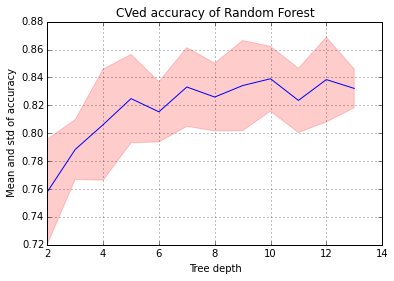

In [22]:
depth = np.array([d for d in acc_depth])
mn = np.array([i[1][0] for i in acc_depth.items()])
sd = np.array([i[1][1] for i in acc_depth.items()])

plt.plot(depth, mn)
plt.fill_between(depth, mn + sd, mn -sd, color='r', alpha = .2)
plt.title('CVed accuracy of Random Forest')
plt.xlabel('Tree depth')
plt.ylabel(' Mean and std of accuracy')
plt.grid();

## Accuracy of trained RF on held-out test set

let's try '7' and '12' as optimal depth

In [23]:
n = 7

mod1_rf = RandomForest.trainClassifier(data = train
                                       ,numClasses = 2
                                       ,categoricalFeaturesInfo ={}
                                       ,numTrees = 1000
                                       ,maxDepth = n
                                       ,seed =1)

predictions = mod1_rf.predict(test.map(lambda x:x.features))
predcitions_labels = test.map(lambda lp: lp.label).zip(predictions)
rf_acc = predcitions_labels.map(lambda x: x[0] == x[1]).mean()

print('Accuracy of Random Forest with depth {} on held-out test set is {:0.2f}'.format(n, rf_acc))

Accuracy of Random Forest with depth 7 on held-out test set is 0.83


In [24]:
n = 12

mod2_rf = RandomForest.trainClassifier(data = train
                                       ,numClasses = 2
                                       ,categoricalFeaturesInfo ={}
                                       ,numTrees = 1000
                                       ,maxDepth = n
                                       ,seed =1)

predictions = mod2_rf.predict(test.map(lambda x:x.features))
predcitions_labels = test.map(lambda lp: lp.label).zip(predictions)
rf_acc = predcitions_labels.map(lambda x: x[0] == x[1]).mean()

print('Accuracy of Random Forest with depth {} on held-out test set is {:0.2f}'.format(n, rf_acc))

Accuracy of Random Forest with depth 12 on held-out test set is 0.83
